# Introduction

The questions I hope to answer in this notebook are:

1. How does pricing compare among all 3 cities throughout the year?
2. How do price distributions compare between each city?
3. Where might you find the highest listing prices in each city?
4. What features of an AirBnB listing influence price for major cities in Spain?

For the first question, I will  use the 'calendars.csv' datasets provided by insideairbnb.com. This dataset contains information on price per listing on any given day of the year.

The second and third questions will be answered with aggregations and visualizations on the data, using the 'listings.csv' datasets.

To answer the third question, I will model a regressor to predict the feature 'prices' using the rest of the features in the dataset.

In [0]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
import seaborn as sns

pd.options.mode.chained_assignment = None
plt.style.use('ggplot')

In [0]:
main = 'drive/My Drive/Colab Notebooks/AirBnB'

# Question 1 - Differences in Listing Price Distributions

I will answer this question in two ways: 

1. I'll first compare the proportion of listings that fall within ranges of prices for each city
2. I'll then compare how the prices fluctuate throughout the year

By answering these questions, I can learn how costs of listings differ from each city - perhaps there is one that is significantly more expensive? I can also learn the composition of high-priced listings (eg. are 10% of listings priced over $100 per night?).

In [9]:
# read in calendars.csv here - inspect files
# from source: insideairbnb.com - calendars.csv files contain detailed calendar data for each listing in the city
bc_cal = pd.read_csv(main+'/barcelona_cal.csv')
md_cal = pd.read_csv(main+'/madrid_cal.csv')
vc_cal = pd.read_csv(main+'/valencia_cal.csv')

bc_cal.name = 'Barcelona'
md_cal.name = 'Madrid'
vc_cal.name = 'Valencia'

print('=====dataset dimensions=====')
print('Barcelona: ', bc_cal.shape)
print('Madrid: ', md_cal.shape)
print('Valencia: ', vc_cal.shape)
print('\n=====column names=====')
print(bc_cal.columns)
print('\n=====Subset=====')
bc_cal.head()

=====dataset dimensions=====
Barcelona:  (7447460, 7)
Madrid:  (7605505, 7)
Valencia:  (2640075, 7)

=====column names=====
Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

=====Subset=====


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,206846,2019-09-17,t,$118.00,$94.00,31,190
1,18666,2019-09-17,f,$130.00,$130.00,3,730
2,18666,2019-09-18,f,$130.00,$130.00,3,730
3,18666,2019-09-19,f,$130.00,$130.00,3,730
4,18666,2019-09-20,f,$130.00,$130.00,3,730


In [10]:
# reformat price information - for this question, I will be looking at the price distribution throughout the year for each city
cal_dfs = [bc_cal, md_cal, vc_cal]

for df in cal_dfs:
    print(f'\n===={df.name}====')
    df['price'] = df['price'].str.replace('[^0-9\.]', '').astype(float)
    print(f"Price column converted to {df['price'].dtype}") # confirm the reformat

    df['date'] = pd.to_datetime(df['date']).dt.date
    print(f"Earliest Date: {df['date'].min()}")
    print(f"Latest Date: {df['date'].max()}")

    date_range = df['date'].max() - df['date'].min()
    print(f"{str(date_range).split(',')[0]} exist in the dataframe")


====Barcelona====
Price column converted to float64
Earliest Date: 2019-09-17
Latest Date: 2020-10-06
385 days exist in the dataframe

====Madrid====
Price column converted to float64
Earliest Date: 2019-09-19
Latest Date: 2020-09-17
364 days exist in the dataframe

====Valencia====
Price column converted to float64
Earliest Date: 2019-09-30
Latest Date: 2020-10-10
376 days exist in the dataframe


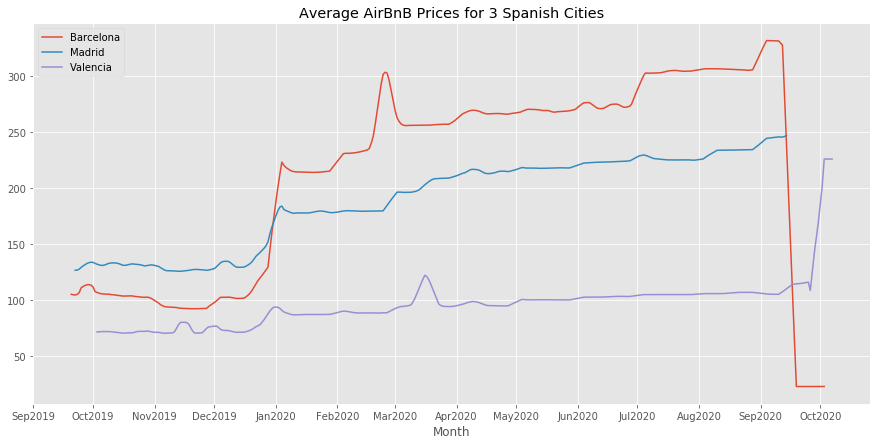

In [0]:
# to plot the average listing price throughout the year, it'd be wise to use a rolling average with a weeklong window
import matplotlib.dates as mat_dates
bc_grouped_price = pd.DataFrame(bc_cal.groupby('date')['price'].mean())
md_grouped_price = pd.DataFrame(md_cal.groupby('date')['price'].mean())
vc_grouped_price = pd.DataFrame(vc_cal.groupby('date')['price'].mean())

plt.figure(figsize=(15,7))
plt.plot(pd.to_datetime(bc_grouped_price.index), bc_grouped_price.rolling(window=7, center=True).mean(), label='Barcelona')
plt.plot(pd.to_datetime(md_grouped_price.index), md_grouped_price.rolling(window=7, center=True).mean(), label='Madrid')
plt.plot(pd.to_datetime(vc_grouped_price.index), vc_grouped_price.rolling(window=7, center=True).mean(), label='Valencia')

date_fmt = pltdates.DateFormatter('%b%Y')
plt.legend()
x_axis = plt.gca().xaxis
x_axis.set_major_locator(mat_dates.MonthLocator())
x_axis.set_major_formatter(date_fmt)

plt.xlabel('Month')
plt.title('Average AirBnB Prices for 3 Spanish Cities')
plt.show()

# Question 1 Conclusion

We can ignore the time period after September 2020, as not all cities contain data for the month of October.. 

For the time period between September 2019 and September 2020, we can see that Barcelona will spike in prices the highest, beginning in January 2020. Similarily the other two cities also rise in prices during this time, but none more significant than Barcelona. 

Prices steadily grow again as the year enters the Spring and Summer seasons. Valencia appears to remain the cheapest throughout the year. Both Barcelona and Madrid experience spikes in average listings price near the end of February and start of March. It should be noted that there is a long weekend during this time period. 

Both cities again experience similar raises and dips in price for what appears to be the first two weeks - in Spanish culture, *Semana Santa* is a week long holiday that happens during this time. Likely, domestic tourists will be mobilizing around the country and hoping to secure holiday destinations. It makes sense that Barcelona is the higher priced, as this is a *very* popular vacation destination from people around the world.

# Question 2 - How Do Price Distributions Differ Between Cities?

In [13]:
# Read all listings and join into one dataframe
# from source: insideairbnb.com - listings.csv file contain detailed listings data for each city
bc_list = pd.read_csv(main + '/barcelona_list.csv')
md_list = pd.read_csv(main + '/madrid_list.csv')
vc_list = pd.read_csv(main + '/valencia_list.csv')

dfs = [bc_list, md_list, vc_list]

# The existing datasets contain a feature named 'city' - however it contains
# names of extending regions, neighbourhoods, and other municipal-related nomenclature. 
# I just want the 3 cities so it's easier to drop & create a new column with the correct cities.
for df in dfs:
    df.drop('city', axis=1, inplace=True)
    df['price'] = df['price'].str.replace('[^0-9\.]', '').astype(float)

bc_list['city'] = 'Barcelona'
md_list['city'] = 'Madrid'
vc_list['city'] = 'Valencia'

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# for convenience sake I'm going to combine the datasets, drop outliers, and plot by city aggregation
all_cities = pd.concat(dfs, ignore_index=True) 
#pd.to_pickle(all_cities, main+'/all_cities_uncleaned.pkl')

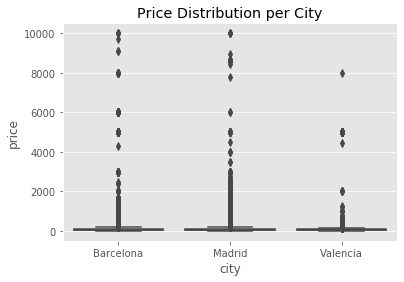

In [67]:
# Let's get a visual on how dispersed the pricing is per city
ax = sns.boxplot(x='city', y = 'price', data=all_cities, )
ax.set_title('Price Distribution per City')
plt.show()

Wow those are some major outliers! I wonder what type of AirBnB is priced at $10,000!! As an expat living on an English teachers' salary, I will never know. I'm going to need to drop some listings. To determine a price threshold, I'll check the count & percentage of listings whose prices fall within some reasonable ranges.

In [39]:
# printing the percentages of listings per price ranges of $500
all_cities.groupby(pd.cut(all_cities['price'], np.arange(0, 10000, 500)))['id'].count()/len(all_cities)

price
(0, 500]        0.973450
(500, 1000]     0.015596
(1000, 1500]    0.004456
(1500, 2000]    0.001238
(2000, 2500]    0.000413
(2500, 3000]    0.000722
(3000, 3500]    0.000041
(3500, 4000]    0.000062
(4000, 4500]    0.000062
(4500, 5000]    0.002558
(5000, 5500]    0.000000
(5500, 6000]    0.000619
(6000, 6500]    0.000000
(6500, 7000]    0.000000
(7000, 7500]    0.000000
(7500, 8000]    0.000268
(8000, 8500]    0.000021
(8500, 9000]    0.000268
(9000, 9500]    0.000041
Name: id, dtype: float64

Looks like 97% of the listings in the combined dataset have prices under 500. This seems like a reasonable threshold. I don't believe it would be very representative of AirBnB's customer base if we conduct an analysis assuming all customers can afford a nightly rate of 500 or more!

In [42]:
# drop price outliers
all_cities_dropped_prices = all_cities[all_cities.price <500]
print(f"{all_cities_dropped_prices.shape[0]} rows remain")

46906 rows remain


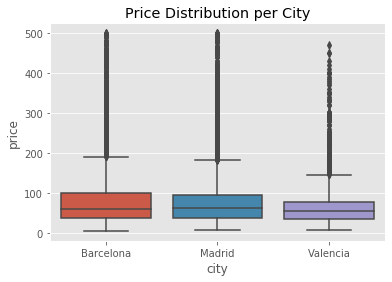

In [43]:
ax = sns.boxplot(x='city', y = 'price', data=all_cities_dropped_prices, )
ax.set_title('Price Distribution per City')
plt.show()

Looking at the boxplots of the dropped prices dataset, we can see that the upper bounds for Barcelona and Madrid don't extend past $200 per night. Valencia is just short of these. The median price hovers between 0 and 100 for each city, with Valencia's being slightly lower than the other two. Let's get these actual figures by dividing the dataset up again by city, and doing a final plot of the proportions per price bin

In [78]:
describe_by_city = pd.DataFrame(group.describe().rename(columns={'price':name}).squeeze()
                         for name, group in all_cities_dropped_prices.groupby('city')['price'])
describe_by_city.set_index(pd.Series(['Barcelona', 'Madrid', 'Valencia']))

,count,mean,std,min,25%,50%,75%,max
Barcelona,19857.0,84.063857,71.195851,6.0,39.0,60.0,100.0,499.0
Madrid,19872.0,81.093951,69.742078,8.0,38.0,62.0,96.0,499.0
Valencia,7177.0,64.503832,46.956997,9.0,35.0,56.0,79.0,470.0


In the dropped prices data, for each city the mean price ranges from $64 - 84. Barcelona and Madrid seem to be on the higher end of pricing. 
Valencia has significantly less listings than the other two cities. 

In [84]:
bc_dropped_price = all_cities_dropped_prices[all_cities_dropped_prices.city=='Barcelona']
md_dropped_price = all_cities_dropped_prices[all_cities_dropped_prices.city=='Madrid']
vc_dropped_price = all_cities_dropped_prices[all_cities_dropped_prices.city=='Valencia']

print("=====Barcelona Price Buckets=====")
print(bc_dropped_price.groupby(pd.cut(bc_dropped_price['price'], np.arange(0, 500, 100)))['id'].count()/len(bc_dropped_price))
print("\n=====Madrid Price Buckets=====")
print(md_dropped_price.groupby(pd.cut(md_dropped_price['price'], np.arange(0, 500, 100)))['id'].count()/len(md_dropped_price))
print("\n=====Valencia Price Buckets=====")
print(vc_dropped_price.groupby(pd.cut(vc_dropped_price['price'], np.arange(0, 500, 100)))['id'].count()/len(vc_dropped_price))

=====Barcelona Price Buckets=====
price
(0, 100]      0.757768
(100, 200]    0.183109
(200, 300]    0.038123
(300, 400]    0.015712
Name: id, dtype: float64

=====Madrid Price Buckets=====
price
(0, 100]      0.794535
(100, 200]    0.150765
(200, 300]    0.035074
(300, 400]    0.014694
Name: id, dtype: float64

=====Valencia Price Buckets=====
price
(0, 100]      0.887139
(100, 200]    0.094329
(200, 300]    0.013794
(300, 400]    0.003901
Name: id, dtype: float64


Text(0.5, 1.0, 'Valencia')

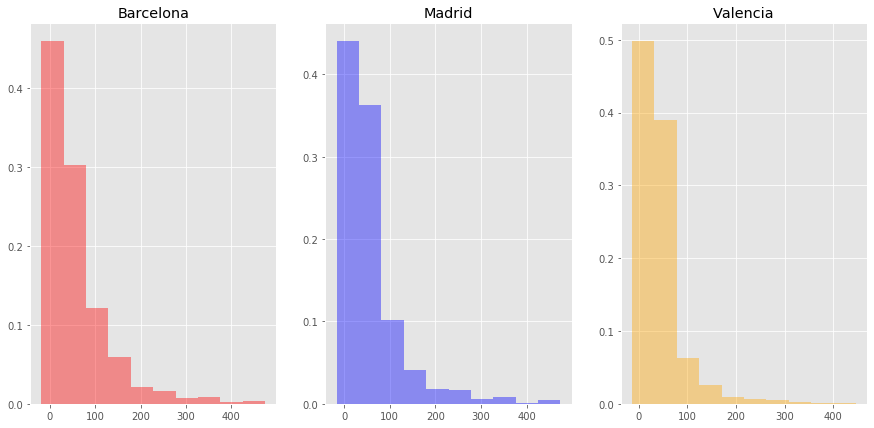

In [85]:
# visualizing the above price buckets using histogram - but with proportions instead of counts
fig, ax = plt.subplots(1,3, figsize=(15, 7))

hist, bins = np.histogram(bc_dropped_price['price'])
ax[0].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='red', alpha=0.4)
ax[0].set_title('Barcelona')

hist, bins = np.histogram(md_dropped_price['price'])
ax[1].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='blue', alpha=0.4)
ax[1].set_title('Madrid')

hist, bins = np.histogram(vc_dropped_price['price'])
ax[2].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='orange', alpha=0.4)
ax[2].set_title('Valencia')

# Question 2 - Conclusion

For all 3 cities of interest, the majority of listings were priced under 500. When outliers above this threshold were dropped, it was found that 75 - 79% of listings price under 100 per night, with the exception of Valencia where 88% of listings are priced under 100. Madrid and Barcelona, both major cities, seem to be more expensive - as seen in Question 1 and here. In Valencia there is more opportunity to find a listing priced more affordably. It should be noted though that Valencia had significantly less listings than the other two cities (which I found odd, as it's a wonderful tourist destination).

In [0]:
all_cities_dropped_prices.to_pickle(main+"/all_cities_dropped_prices.pkl")

# Question 3 - Most Expensive Neighbourhoods

Where are the most expensive listings in each city? I've decided to answer this question using the dataset I just created, where nightly rates of 500 or more were dropped. We can do a group and aggregate by average price per city:



In [0]:
all_cities_dropped_prices = pd.read_pickle(main+"/all_cities_dropped_prices.pkl")

#bc_dropped_price = all_cities_dropped_prices[all_cities_dropped_prices.city=='Barcelona']
#md_dropped_price = all_cities_dropped_prices[all_cities_dropped_prices.city=='Madrid']
#vc_dropped_price = all_cities_dropped_prices[all_cities_dropped_prices.city=='Valencia']

In [0]:
def group_prices_by_location(df):
    """Returns a new dataframe where average 'prices' have been aggregated for each neighbourhood.
    A column on how many listings for each neighbourhood is also created.
    
    df: the dataset containing AirBnB information
    """

    df_agg = pd.DataFrame(data={'mean_price': df.groupby('neighbourhood_cleansed')['price'].mean(),
                               'listings_count': df.groupby('neighbourhood_cleansed')['price'].count()})
    
    df_agg.sort_values(by='mean_price', axis=0, ascending=False, inplace=True)

    return df_agg

bc_avg_prices = group_prices_by_location(bc_dropped_price)

md_avg_prices = group_prices_by_location(md_dropped_price)
vc_avg_prices = group_prices_by_location(vc_dropped_price)

In [0]:
# select top 7 neighbourhoods by mean price
bc_top_hoods = bc_avg_prices['mean_price'].nlargest(5)
md_top_hoods = md_avg_prices['mean_price'].nlargest(5)
vc_top_hoods = vc_avg_prices['mean_price'].nlargest(5)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

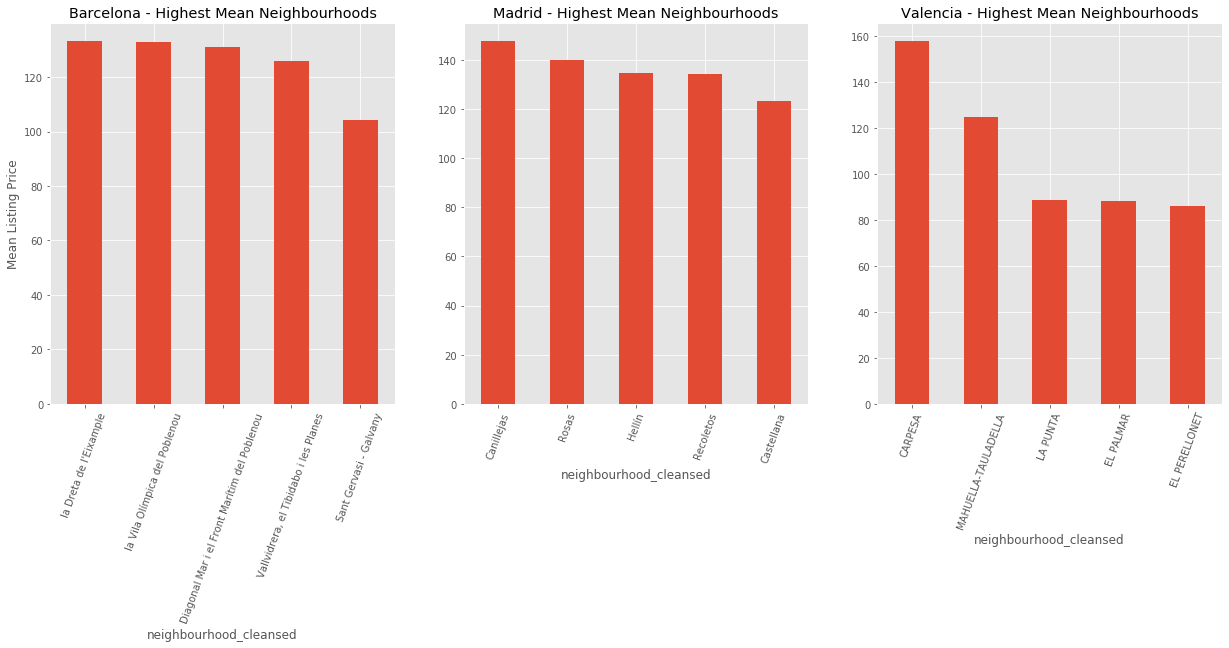

In [108]:
plt.figure(figsize=(21,7))

axa = plt.subplot(131)
axa.set_title('Barcelona - Highest Mean Neighbourhoods')
axa.set_ylabel('Mean Listing Price')
bc_top_hoods.plot(kind='bar', ax=plt.gca())
plt.xticks(rotation=70)

axb = plt.subplot(132)
axb.set_title('Madrid - Highest Mean Neighbourhoods')
md_top_hoods.plot(kind='bar', ax=plt.gca()) 
plt.xticks(rotation=70)

axc = plt.subplot(133)
axc.set_title('Valencia - Highest Mean Neighbourhoods')
vc_top_hoods.plot(kind='bar', ax=plt.gca())
plt.xticks(rotation=70)


In [0]:
# selecting data from the dataframes for the top 5 hoods
bc_expensive_hoods = bc_dropped_price[bc_dropped_price['neighbourhood_cleansed'].isin(bc_top_hoods.index)]
md_expensive_hoods = md_dropped_price[md_dropped_price['neighbourhood_cleansed'].isin(md_top_hoods.index)]
vc_expensive_hoods = vc_dropped_price[vc_dropped_price['neighbourhood_cleansed'].isin(vc_top_hoods.index)]

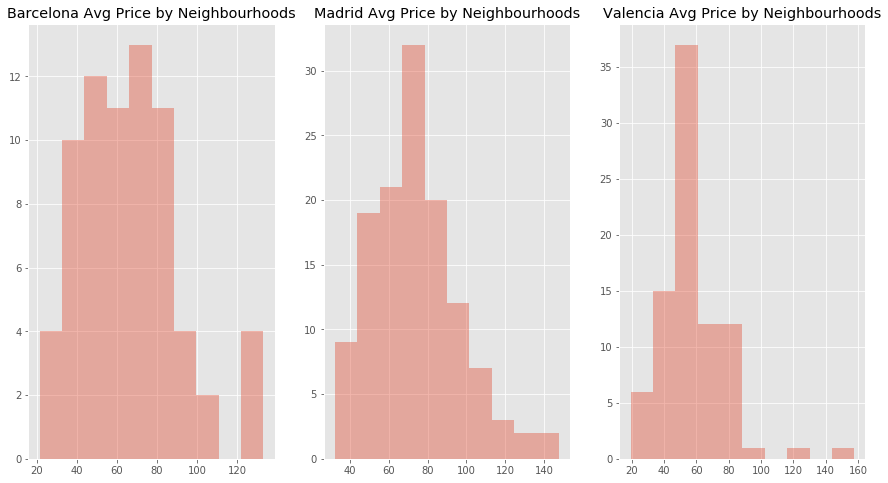

In [113]:
plt.figure(figsize=(15,8))
axa = plt.subplot(131)
axa.set_title('Barcelona Avg Price by Neighbourhoods')
bc_avg_prices['mean_price'].hist(alpha=0.4, bins=10)

axb = plt.subplot(132)
axb.set_title('Madrid Avg Price by Neighbourhoods')
md_avg_prices['mean_price'].hist(alpha=0.4, bins=10)

axc = plt.subplot(133)
axc.set_title('Valencia Avg Price by Neighbourhoods')
vc_avg_prices['mean_price'].hist(alpha=0.4, bins=10)

Average neighbourhood price distributions for all 3 cities experience skewness, with higher proportions of listings appearing on the left-side of the plot. In Valencia, nearly 40% of the neighbourhoods have an average listing price anywhere between $50 and 60 a night. In Madrid, nearly 35% of the neighbourhoods have an average listing price in a higher bin at 70 to 80. 

Barcelona's average neighbourhood prices don't reach as high proportions. In Barcelona's histogram, we can see how it results in being the more expensive of the 3 cities, with 4% of its neighbourhoods averaging over $120 a night. In the other two cities, there are higher average reached but the proportion of neighbourhoods are not as high. One can argue that Valencia would be a good destination to look into for higher priced, luxury listings - though there will not be as many options as one might find in Barcelona.

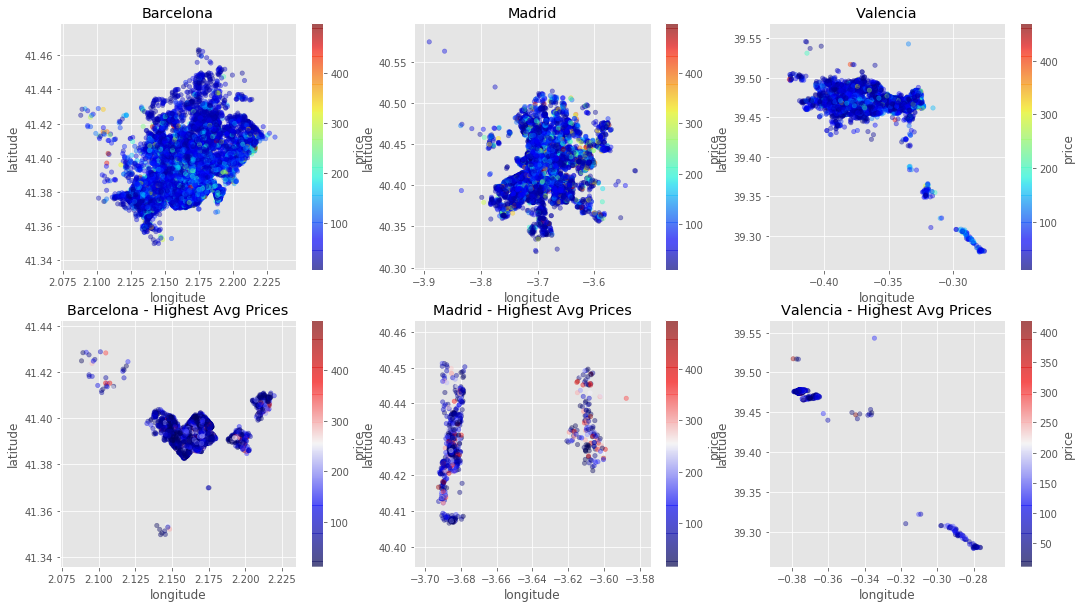

In [106]:
# visualizing locations using longitude and latitude
# first column of the subplot will scatterplot listing lat-long coordinates and colour by price
# second column of the subplot will scatterplot listings from the Most Expensive hoods and colour by price
# third column will provide a histogram for neighbourhood counts by average price listing

plt.figure(figsize=(18, 10))
ax1 = plt.subplot(231)
ax1.set_title('Barcelona')
bc_dropped_price.plot.scatter(x="longitude", y="latitude", alpha=0.4,
            c="price", cmap=plt.get_cmap("jet"), colorbar=True,ax=plt.gca())


ax2 = plt.subplot(232)
ax2.set_title('Madrid')
md_dropped_price.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            c="price", cmap=plt.get_cmap("jet"), colorbar=True, ax=plt.gca())


ax3 = plt.subplot(233)
ax3.set_title('Valencia')
vc_dropped_price.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            c="price", cmap=plt.get_cmap("jet"), colorbar=True, ax=plt.gca())


ax4 = plt.subplot(234)
ax4.set_title('Barcelona - Highest Avg Prices')
bc_expensive_hoods.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            c="price", cmap=plt.get_cmap("seismic"), colorbar=True, ax=plt.gca())

ax5 = plt.subplot(235)
ax5.set_title('Madrid - Highest Avg Prices')
md_expensive_hoods.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            c="price", cmap=plt.get_cmap("seismic"), colorbar=True, ax=plt.gca())

ax6 = plt.subplot(236)
ax6.set_title('Valencia - Highest Avg Prices')
vc_expensive_hoods.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            c="price", cmap=plt.get_cmap("seismic"), colorbar=True, ax=plt.gca())



# Question 3 - Conclusion
In the above scatter plots, I have visualized the listings by their latitude and longitudinal coordinates and coloured the points by price (under $500, as I am using the dropped prices dataset created earlier). The top row visualizes all neighbourhoods, coloured by price. The second row is a visualization of the listings in the neighbourhoods with the 5 highest average listing price. 

In Barcelona, these highest averaging hoods are clustered in the 3 distinct groups, with the highest priced properties scattered on the outskirts of the city. The 3 distinct groups appear to be on the waterfront of the city (if you are familiar with Barcelona's geography). These properties are likey in the historic districts of the city, or in the more modern luxury properties that overlook the Mediterranean. 

In Madrid, it appears the highest average hoods lie on the outskirts of the city centre. I am surprised to find this, as I previously supposed the highest valued listings would be in the city's bustling historic core. Perhaps there are luxury properties and estates outside of this core that are attractive to business-oriented, affluent, travellers.

In Valencia, expensive listings seem to be relatively sparse. Some dense clustering of expensive properties occur on the perimeters of the supposed city core. This city is located on a stretch of beautiful natural beaches, so it would be only fair to assume that these more expensive listings are beach get-aways or luxury destinations. 

# Handling Data for Question 4 - What Features Influence Prices in All Cities?

What features can be detected as contributing to a listing's price? This is a regression problem - I will create a linear model wherein I predict a listing's price based on the independent X variables. I hope to achieve a model which is able to explain as much of the variance between my predicted values and the observed ones in the dataset. Before I can begin, however, I must clean the data so that it is able to be fed into a Regression model.
    
    Order of Operations:
        - Drop redundant, problematic, or excess features
        - Deal with missing values
        - Ensure numerical features are able to be used
        - Deal with categorical features accordingly
        - Imputation & Standardization (scaling)
        - Modelling
        - Predicting
        - Conclusion

## Dropping Redundant, Problematic or Excess Features
The listings are combined into one dataset, and the 'city' feature contains either 'Madrid', 'Barcelona', or 'Valencia'. This is easier to do than working with 3 separate datasets at a time. This also ensures that uniform  preprocessing & transformations are conducted on all listings.

The dataset contains many fields that are text information (neighbourhood_overview, name, description, interactions, access, etc..).

While this provides the opportunity to create NLP-based features (POS, count vectors, tfidf-scores etc.), we will not explore this domain for brevity's sake. 

Therefore, I made the decision to closely examine these text-based features and discard those that can not be categorized easily. 

In addition to the text-heavy features I don't want to parse, I have also made the decision to drop some numerical features that seemed redundant for the analyses I will be conducitng (for example, Maximum_maximum_nights/maximum_minimum_nights, scraping_dates & host info seemed excessive to include).


In [0]:
def drop_columns(df):
    """Returns a dataframe in which the irrelevant feature columns have been dropped.
    df: Pandas DataFrame, a dataframe containing all AirBnB listings data.
    """
    
    droplist_1 = ['name', 'summary', 'space', 'scrape_id', 'host_id', 'description', 'neighborhood_overview', 'notes', 'transit', 'access',
        'interaction', 'host_name', 'host_listings_count', 'is_location_exact', 'host_about', 'host_verifications', 
        'host_neighbourhood', 'host_location', 'house_rules', 'street', 'calendar_last_scraped', 'last_scraped','country_code',
        'country', 'zipcode', 'state', 'market', 'smart_location', 'zipcode', 'host_has_profile_pic', 
        'host_identity_verified', 'neighbourhood_group_cleansed', 'neighbourhood', 'latitude', 'longitude',
        'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
        'maximum_maximum_nights', 'calendar_updated', 'number_of_reviews', 'calendar_updated', 
        'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
        'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
        'require_guest_phone_verification', 'require_guest_profile_picture'
        ]
        
    df.drop(labels=droplist_1, axis=1, inplace=True)

    # remove columns that contain urls - these are not relevant
    url_cols = [col for col in df.columns if col.endswith('url')]
    df.drop(labels=url_cols, axis=1, inplace=True)

    # remove columns where there is no variability
    only_one_value = [col for col in df.columns if len(df[col].unique()) == 1]
    df.drop(labels=only_one_value, axis=1, inplace=True)
    print('Dropped {} Columns'.format(len(droplist_1)+len(url_cols)+len(only_one_value)))

    return df

In [115]:
all_cities_dropped_cols = drop_columns(all_cities_dropped_prices)

Dropped 62 Columns


## Dealing with Missing Values

It appears that missing values in this dataset appear consistently as NaN values. So we will not need to do additional legwork in re-encoding these to the proper format. 
Below, I have found the percentage of NaN values per columns and sorted columns by percentage. There are clear outlier columns: 

    square_feet - 98%
    monthly_price - 93%
    weekly_price - 93%
    license - 61%

Conducting analyses with these features is not ideal. So  I have decided to drop them now.

In total, we have 22 columns where there are missing values. 18 of these columns have over 10% of their values missing.

In [116]:
round(all_cities_dropped_cols.isnull().sum()/len(all_cities_dropped_cols), 3).sort_values(ascending=False).head(22)

square_feet                    0.980
weekly_price                   0.925
monthly_price                  0.925
license                        0.609
security_deposit               0.303
cleaning_fee                   0.218
review_scores_accuracy         0.203
review_scores_rating           0.203
review_scores_cleanliness      0.203
review_scores_checkin          0.203
review_scores_communication    0.203
review_scores_location         0.203
review_scores_value            0.203
reviews_per_month              0.190
last_review                    0.190
first_review                   0.190
host_response_rate             0.146
host_response_time             0.146
beds                           0.002
host_is_superhost              0.001
host_total_listings_count      0.001
host_since                     0.001
dtype: float64

In [117]:
all_cities_dropped_cols.drop(labels=['square_feet', 'monthly_price', 'weekly_price', 'license'], axis=1, inplace=True)
all_cities_dropped_cols.shape

(46906, 42)

We should also check the records of the dataset for rows in which most column values are missing. A listing is only useful in my experiment if it has comprehensive information to offer. We have ~56 columns. If a listing has NaN values for 50% of those columns, it may not be very useful for us.


In [0]:
row_nans = pd.DataFrame(all_cities_dropped_cols.isnull().sum(axis=1)/len(all_cities_dropped_cols.columns))

Text(0.5, 1.0, 'Row-wise NaN Value Counts')

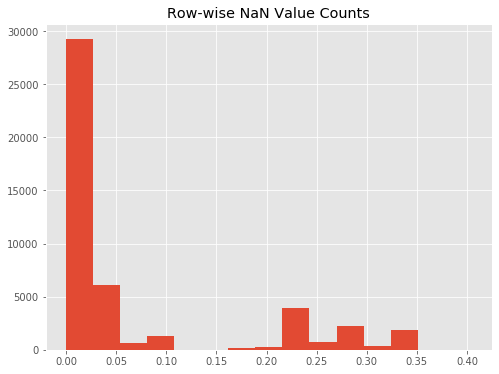

In [119]:
row_nans.hist(bins=15, figsize=(8,6))
plt.title('Row-wise NaN Value Counts')

In [0]:
rows_to_keep = row_nans[row_nans[0] < 0.2].index

data_pre_clean = all_cities_dropped_cols.loc[rows_to_keep]

In [121]:
data_pre_clean.shape

(37625, 42)

In [0]:
pd.to_pickle(data_pre_clean, main+'/data_pre_cleaning.pkl')

## Handling the Numerical Data

There are 31 numerical features to inspect and format properly for regression. Some things I need to handle are removing special string characters from columns such as '%' and '$'. Then I will create three new features from datetime objects & the 'amenities' column: 

1. 'review_span' will be the difference in days between the 'first_review' & 'last_review' date
2. 'host_span' will be the difference in days between the 'host_since' date and the current date (which at time of writing is 2019-12-03). 
3. 'total_listed_amenities' will be the number of amenities the host has provided in the AirBnB listing. 


In [124]:
number_cols = ['first_review', 'last_review', 'host_since', 'host_response_rate','amenities',
                   'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 
                   'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm', 
                   'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
                   'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                   'review_scores_checkin','review_scores_communication','review_scores_location', 'review_scores_value', 
                   'reviews_per_month', 'host_total_listings_count']

numerical_data = data_pre_clean[number_cols]
print(numerical_data.shape)

numerical_data.head()

(37625, 32)


,first_review,last_review,host_since,host_response_rate,amenities,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_total_listings_count
0,2015-10-10,2015-10-10,2010-01-19,95%,"{TV,Internet,Wifi,""Air conditioning"",""Wheelcha...",6,1.0,2.0,4.0,130.0,$150.00,$42.00,2,$25.00,3,730,3.0,730.0,0,0,0,251,0,80.0,10.0,10.0,2.0,10.0,10.0,8.0,0.02,47.0
1,2013-05-27,2019-08-04,2010-01-19,95%,"{TV,Internet,Wifi,""Air conditioning"",""Wheelcha...",8,2.0,3.0,6.0,60.0,$150.00,$50.00,2,$30.00,1,1125,1.9,1125.0,13,31,43,52,11,85.0,9.0,9.0,9.0,10.0,9.0,8.0,0.21,47.0
2,2016-05-08,2019-09-08,2010-02-18,100%,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...",2,1.0,1.0,1.0,33.0,$100.00,NaN,1,$10.00,2,1125,2.1,1125.0,3,3,3,3,31,90.0,10.0,9.0,10.0,10.0,9.0,9.0,3.05,2.0
3,2011-03-15,2019-09-10,2010-03-09,100%,"{TV,Internet,Wifi,""Wheelchair accessible"",Kitc...",6,2.0,3.0,5.0,210.0,$300.00,$80.00,3,$10.00,3,1125,3.1,1125.0,10,33,56,326,17,94.0,10.0,10.0,10.0,10.0,9.0,9.0,0.47,5.0
4,2010-08-11,2019-09-10,2010-04-14,100%,"{TV,Wifi,""Air conditioning"",Kitchen,""Smoking a...",2,1.0,1.0,1.0,45.0,NaN,NaN,1,$25.00,1,730,1.0,730.0,10,31,41,77,48,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.29,1.0


In [0]:
# create new feature: total_amenities_listed
def count_total_amenities(amstring):
    """Returns the count of amenities found in an AirBnB listing.
    
    amstring: str, a list or set of AirBnB amenities formatted as a string type
    """
    return len(amstring.split(','))

numerical_data['total_listed_amenities'] = numerical_data['amenities'].apply(count_total_amenities)
numerical_data.drop('amenities', axis=1, inplace=True)

In [126]:
#handle remaining special string characters - $ and %
for col in ('security_deposit', 'cleaning_fee', 'extra_people'):
    numerical_data[col] = numerical_data[col].str.replace('[^0-9\.]', '').astype(float)

numerical_data['host_response_rate'] = numerical_data['host_response_rate'].str.replace('\%', '').astype(float)

# create new features: host_span & review_span. These will indicate how many days
# the host has been on AirBnB, and how many days between the review dates has passed.
from datetime import date
numerical_data['review_span'] = (pd.to_datetime(numerical_data['last_review']) - pd.to_datetime(numerical_data['first_review']))/np.timedelta64(1, 'D')
numerical_data['host_span'] = (pd.to_datetime(date.today()) - pd.to_datetime(numerical_data['host_since']))/np.timedelta64(1, 'D')

numerical_data.drop(labels = ['first_review', 'last_review', 'host_since'],axis=1 , inplace=True)
print(numerical_data.shape)

(37625, 31)


## Dealing with Categorical Features (incl. Binary)

There are several columns here that cannot be used in the modelling I wish to perform - given that they contain non-numerical data. So I'll write a function to take care of these fields:

    1. property_type
    2. room_type
    3. bed_type
    4. host_response_time
    5. neighbourhood_cleansed
    6. cancellation_policy
    7. cities

I would like to understand most important features later on when I run a regression, and in the event that a particular neighbourhood, property or room type influence pricing - I would like to know which one. 

For this reason, I will One-Hot Encode all the categorical features, except 'host_response_time' - which contains Null Values and will not work with the Scikit-learn encoding function.

My dataset also has 'host_is_superhost', and 'instant_bookable' which I will encode to numeric binary values.



In [0]:
cat_feats = data_pre_clean[['city','host_is_superhost', 'instant_bookable','property_type', 'room_type', 'bed_type', 
                              'host_response_time', 'neighbourhood_cleansed', 'cancellation_policy']]

In [128]:
cat_feats.head()

,city,host_is_superhost,instant_bookable,property_type,room_type,bed_type,host_response_time,neighbourhood_cleansed,cancellation_policy
0,Barcelona,f,f,Apartment,Entire home/apt,Real Bed,within an hour,el Camp de l'Arpa del Clot,flexible
1,Barcelona,f,t,Apartment,Entire home/apt,Real Bed,within an hour,la Sagrada Família,strict_14_with_grace_period
2,Barcelona,f,f,Apartment,Private room,Real Bed,within a few hours,el Poblenou,moderate
3,Barcelona,t,t,Apartment,Entire home/apt,Real Bed,within an hour,el Besòs i el Maresme,strict_14_with_grace_period
4,Barcelona,t,t,Apartment,Private room,Real Bed,within an hour,la Vila de Gràcia,strict_14_with_grace_period


In [0]:
def convert_binary_feats(df, col):
    """Maps numerical value to non-numerical categories where the category type is binary
    df: Pandas DataFrame, dataframe containing binary features
    col: str, the name of the columns containing binary features
    """
    df[col] = df[col].map({'t':1, 'f':0})
    return df[col]

for col in ('host_is_superhost', 'instant_bookable'):
    cat_feats[col] = convert_binary_feats(cat_feats, col)

In [130]:
cat_feats.shape

(37625, 9)

In [131]:
for col in cat_feats.columns:
    print(col, len(cat_feats[col].unique()))

city 3
host_is_superhost 3
instant_bookable 2
property_type 33
room_type 4
bed_type 5
host_response_time 5
neighbourhood_cleansed 282
cancellation_policy 6


In [132]:
cat_feats.head()

,city,host_is_superhost,instant_bookable,property_type,room_type,bed_type,host_response_time,neighbourhood_cleansed,cancellation_policy
0,Barcelona,0.0,0,Apartment,Entire home/apt,Real Bed,within an hour,el Camp de l'Arpa del Clot,flexible
1,Barcelona,0.0,1,Apartment,Entire home/apt,Real Bed,within an hour,la Sagrada Família,strict_14_with_grace_period
2,Barcelona,0.0,0,Apartment,Private room,Real Bed,within a few hours,el Poblenou,moderate
3,Barcelona,1.0,1,Apartment,Entire home/apt,Real Bed,within an hour,el Besòs i el Maresme,strict_14_with_grace_period
4,Barcelona,1.0,1,Apartment,Private room,Real Bed,within an hour,la Vila de Gràcia,strict_14_with_grace_period


In [0]:
from sklearn.preprocessing import OneHotEncoder

def encode_feats(df, col):
    """Applies a OneHotEncoder to a series of categorical data
    
    df: Pandas DataFrame, dataframe containing categorical features
    col: str, the name of the columns containing categorical features
    """
    encodr = OneHotEncoder(sparse=False)
    encdd = encodr.fit_transform(np.array(df[col]).reshape(-1,1))
    labels = [col.split('_')[0]+'_'+cat.split('_')[1] for cat in encodr.get_feature_names()]
    encdd = pd.DataFrame(encdd, columns=labels)
    print(f'{encdd.shape[1]} new feature columns created')
    return encdd

In [134]:
encoded_dfs = []

for col in ('city', 'property_type', 'cancellation_policy', 'bed_type', 'room_type'):
    encoded_dfs.append(encode_feats(cat_feats, col))

encoded = pd.concat(encoded_dfs, axis=1)

3 new feature columns created
33 new feature columns created
6 new feature columns created
5 new feature columns created
4 new feature columns created


In [135]:
encoded.head()

,city_Barcelona,city_Madrid,city_Valencia,property_Aparthotel,property_Apartment,property_Barn,property_Bed and breakfast,property_Boat,property_Boutique hotel,property_Bungalow,property_Bus,property_Cabin,property_Camper/RV,property_Casa particular (Cuba),property_Castle,property_Chalet,property_Condominium,property_Cottage,property_Dome house,property_Earth house,property_Farm stay,property_Guest suite,property_Guesthouse,property_Hostel,property_Hotel,property_House,property_Hut,property_Island,property_Loft,property_Other,property_Serviced apartment,property_Tent,property_Tiny house,property_Townhouse,property_Vacation home,property_Villa,cancellation_flexible,cancellation_moderate,cancellation_strict,cancellation_strict,cancellation_super,cancellation_super,bed_Airbed,bed_Couch,bed_Futon,bed_Pull-out Sofa,bed_Real Bed,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [136]:
import operator
def map_categorical(df, col_name):
    """Converts categorical data of non-numerical type to type int. 
    
    df: Pandas DataFrame, dataframe containing categorical features
    col_name: str, the name of the columns containing categorical features
    """
    cat_map = {v: k for k, v in dict(enumerate(df[col_name].unique())).items()}
    df[col_name] = df[col_name].map(cat_map)

    cat_map = sorted(cat_map.items(), key=operator.itemgetter(1))
    print(f'Encoded {len(cat_map)} categories for {col_name}')
    return df[col_name], cat_map

cat_feats['host_response_time'], hrt_map = map_categorical(cat_feats, 'host_response_time')
cat_feats['neighbourhood_cleansed'], nbr_map = map_categorical(cat_feats, 'neighbourhood_cleansed') # to be used for Question 1

Encoded 5 categories for host_response_time
Encoded 282 categories for neighbourhood_cleansed


In [137]:
cat_feats.head()

,city,host_is_superhost,instant_bookable,property_type,room_type,bed_type,host_response_time,neighbourhood_cleansed,cancellation_policy
0,Barcelona,0.0,0,Apartment,Entire home/apt,Real Bed,0,0,flexible
1,Barcelona,0.0,1,Apartment,Entire home/apt,Real Bed,0,1,strict_14_with_grace_period
2,Barcelona,0.0,0,Apartment,Private room,Real Bed,1,2,moderate
3,Barcelona,1.0,1,Apartment,Entire home/apt,Real Bed,0,3,strict_14_with_grace_period
4,Barcelona,1.0,1,Apartment,Private room,Real Bed,0,4,strict_14_with_grace_period


In [138]:
encoded['host_is_superhost'] = cat_feats['host_is_superhost']
encoded['host_response_time'] = cat_feats['host_response_time']
encoded['instant_bookable'] = cat_feats['instant_bookable']
encoded['neighbourhood_encoded'] = cat_feats['neighbourhood_cleansed']
categorical_data = encoded
print(f'Categorical_data contains {categorical_data.shape[0]} data points &\
 {categorical_data.shape[1]} feature columns')

Categorical_data contains 37625 data points & 55 feature columns


In [0]:
categorical_data.reset_index(drop=True, inplace=True)
numerical_data.reset_index(drop=True, inplace=True)

cleaned_data = pd.concat([categorical_data, numerical_data], axis=1)

In [0]:
pd.to_pickle(cleaned_data, main+'/cleaned_data.pkl')

# Imputation & Standardization

I can now combine the categorical and numerical features into one dataset. The final step before running any predictive analysis on the data will be to normalize. I will be using a scaler provided by Scikit-Learn. For this process I will take the following steps:

1. Mask Null values out of the dataset - only use a subset of the data in which no Null values exists
2. Fit the Scaler model
3. Impute Null values on the true dataset
4. Transform the imputed data with our fitted scaler

I have selected Scikit-Learn's RobustScaler for standardizing the data. This scaler works well with large datasets that could be prone to outliers. Outliers throughout the dataset can undermine scaling using the mean and variance, therefore it would be more intuitive to use a scaler that scales according to the IQR (inner-quartile range). 

Below I have plotted some boxplots to show how some numerical feature values might be impacted by outliers. You will see that outliers can have a very large impact on how well the data will be scaled.

In [0]:
cleaned_data = pd.read_pickle(main+'/cleaned_data.pkl')

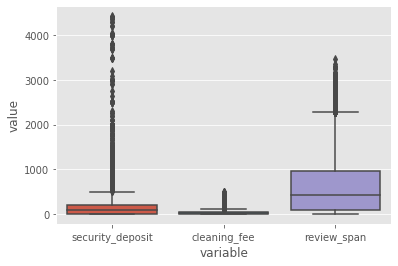

In [142]:
import seaborn as sns
sns.boxplot(x="variable", y="value", data=pd.melt(cleaned_data[['security_deposit', 'cleaning_fee', 'review_span']]))
plt.show()

In [143]:
data_no_null = cleaned_data.dropna()
data_no_null.shape

(20227, 86)

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

imp = SimpleImputer(strategy='mean')

imputed_data = imp.fit_transform(cleaned_data)

scaler = RobustScaler()

fitted_scaler = scaler.fit(data_no_null)

scaled_data = pd.DataFrame(fitted_scaler.transform(imputed_data), columns=cleaned_data.columns)

In [145]:
scaled_data.head()

,city_Barcelona,city_Madrid,city_Valencia,property_Aparthotel,property_Apartment,property_Barn,property_Bed and breakfast,property_Boat,property_Boutique hotel,property_Bungalow,property_Bus,property_Cabin,property_Camper/RV,property_Casa particular (Cuba),property_Castle,property_Chalet,property_Condominium,property_Cottage,property_Dome house,property_Earth house,property_Farm stay,property_Guest suite,property_Guesthouse,property_Hostel,property_Hotel,property_House,property_Hut,property_Island,property_Loft,property_Other,property_Serviced apartment,property_Tent,property_Tiny house,property_Townhouse,property_Vacation home,property_Villa,cancellation_flexible,cancellation_moderate,cancellation_strict,cancellation_strict,...,bed_Real Bed,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,host_is_superhost,host_response_time,instant_bookable,neighbourhood_encoded,host_response_rate,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_total_listings_count,total_listed_amenities,review_span,host_span
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.666667,-1.666667,0.666667,0.0,1.0,1.0,1.111111,0.150000,0.342857,0.0,1.000000,0.5,-0.370892,0.909091,-0.370892,-0.5,-0.884615,-1.146341,0.344262,-0.444444,-1.750,0.0,0.0,-8.0,0.0,0.0,-1.0,-0.639831,3.384615,-0.3125,-0.554113,1.500534
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651515,-1.666667,1.333333,2.0,2.0,2.0,-0.185185,0.150000,0.571429,0.0,1.333333,-0.5,0.000000,-0.090909,0.000000,0.8,0.307692,-0.097561,-0.471311,-0.037037,-1.125,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-0.559322,3.384615,-0.0625,1.891775,1.500534
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,...,0.0,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,-0.636364,0.000000,-0.666667,0.0,0.0,-0.5,-0.685185,-0.100000,0.092136,-0.5,0.000000,0.0,0.000000,0.090909,0.000000,-0.2,-0.769231,-1.073171,-0.672131,0.703704,-0.500,0.0,-1.0,0.0,0.0,-1.0,0.0,0.644068,-0.076923,1.1250,0.764069,1.479159
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.621212,0.000000,0.666667,2.0,2.0,1.5,2.592593,0.900000,1.428571,0.5,0.000000,0.5,0.000000,1.000000,0.000000,0.5,0.384615,0.219512,0.651639,0.185185,0.000,0.0,0.0,0.0,0.0,-1.0,0.0,-0.449153,0.153846,1.4375,2.801948,1.465622
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.606061,0.000000,-0.666667,0.0,0.0,-0.5,-0.462963,0.224048,0.092136,-0.5,1.000000,-0.5,-0.370892,-0.909091,-0.370892,0.5,0.307692,-0.146341,-0.368852,1.333333,0.125,0.0,0.0,0.0,0.0,0.0,1.0,0.322034,-0.153846,-0.3750,3.035714,1.439971


In [0]:
pd.to_pickle(scaled_data, main+'/scaled_data.pkl')

In [0]:

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pprint
from time import time

scaled_data = pd.read_pickle(main+'/scaled_data.pkl')

In [148]:
scaled_data.shape

(37625, 86)

In [149]:
# split the data 70-30
X = scaled_data.loc[:, scaled_data.columns != 'price']
y = scaled_data['price'] # the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

print(f"{len(y_train)} data points available for training")
print(f"{len(y_test)} data points available for testing")

26337 data points available for training
11288 data points available for testing


In [0]:
# Initial baseline prediction with a RandomForestRegressor - default parameters

rfr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, random_state=42)

t0 = time()
rfr.fit(X_train, y_train)

rf_train_pred = rfr.predict(X_train)
rf_y_pred = rfr.predict(X_test)
t1 = time() - t0

rf_train_score = r2_score(y_train, rf_train_pred)
rf_test_score = r2_score(y_test, rf_y_pred)

rf_train_mse = mean_squared_error(y_train, rf_train_pred)
rf_test_mse = mean_squared_error(y_test, rf_y_pred)

In [0]:
# Initial baseline prediction with a GradientBoostingRegressor - default parameters

gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, random_state=42)

t3 = time()
gbr.fit(X_train, y_train)

gb_train_pred = gbr.predict(X_train)
gb_y_pred = gbr.predict(X_test)
t4 = time() - t3

gb_train_score = r2_score(y_train, gb_train_pred)
gb_test_score = r2_score(y_test, gb_y_pred)

gb_train_mse = mean_squared_error(y_train, gb_train_pred)
gb_test_mse = mean_squared_error(y_test, gb_y_pred)

In [152]:
print("=============RandomForest Baseline Prediction================")
print(f"\nRF Training R2: {rf_train_score}")
print(f"RF Testing R2: {rf_test_score}")

print(f"\nRF Training MSE: {rf_train_mse}")
print(f"RF Testing MSE: {rf_test_mse}")
print(f"\nRun Time: {t1} seconds")

print("\n=============GradientBoosting Baseline Prediction=============")
print(f"\nGBR Baseline Training Data R2: {gb_train_score}")
print(f"GBR Baseline Testing Data R2: {gb_test_score}")

print(f"\nGBR Training MSE: {gb_train_mse}")
print(f"GBR Testing MSE: {gb_test_mse}")
print(f"\nRun Time: {t4} seconds")

=============RandomForest Baseline Prediction================

RF Training R2: 0.9562899932817817
RF Testing R2: 0.6889381663446554

RF Training MSE: 0.05966662893685749
RF Testing MSE: 0.43045909032827034

Run Time: 44.19190835952759 seconds

=============GradientBoosting Baseline Prediction=============

GBR Baseline Training Data R2: 0.6448863627494983
GBR Baseline Testing Data R2: 0.6217710864726708

GBR Training MSE: 0.4847501799951034
GBR Testing MSE: 0.5234074271973186

Run Time: 5.826072454452515 seconds


If we look at our baseline predictions, we can see that the RandomForest overfits the data. The testing score isn't bad though! The R-square values are higher than that of the GradientBooster, and it may (or may not) be difficult to remove the overfitting with proper tuning.

However, I feel inclined to go with the GradientBooster. RandomForest is showing signs of overfitting from the get-go, and I'm afraid that tuning will be time intensive as I will need to add a lot more trees to reduce the variance. The R-square values from the GradientBooster can potentially be improved in a stable manner. This algorithm also can outperform RandomForests, when properly tuned, thanks to its 'Early Stopping' abilities - which reduces overfitting by assessing model performance during fitting. Increasing the number of estimators, and countering this with an appropriate learning_rate could also yield a decent linear prediction.

In [161]:
gb = GradientBoostingRegressor(n_iter_no_change=5, random_state=42) # early stopping enabled

param_grid = {'n_estimators':[700, 800, 900, 1000],
                'learning_rate': [0.001, 0.01, 0.05, 0.1],
                'max_features': ['sqrt', 0.3, 0.4, 0.5, 0.6],
                'min_samples_split': [2, 3, 4]}

clf = RandomizedSearchCV(gb, param_grid, n_iter=30, n_jobs=4, cv=5, verbose=10, random_state=42)

start_time = time()
rand_search = clf.fit(X_train, y_train)
run_time = time() - start_time

print(f"\nBest Score across ALL searched params: {rand_search.best_score_}")
print(f"\nSearch Runtime: {run_time} seconds")

print("\n====== Best Parameters ======")
best_params = rand_search.best_params_
pprint.pprint(best_params)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 12.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 15.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 18.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 20.0min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 21.0min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 24.5min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 26.6min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 27.8min finished



Best Score across ALL searched params: 0.6595829322301887

Search Runtime: 1679.6099953651428 seconds

====== Best Parameters ======
{'learning_rate': 0.1,
 'max_features': 0.6,
 'min_samples_split': 4,
 'n_estimators': 800}


In [0]:
def apply_regression(model, X, y):
    """Fits and predict a model on X, y. Prints out R-square value & Mean Square Error.
    Returns a fitted model
    
    model: estimator, a chosen regressor with selected parameters
    X: DataFrame, contains features for prediction. Must comply with 'model' restrictions/requirements for fitting
    y: Series or array, target variable of shape (n_rows in X, )
    """
    t0 = time()
    fitted = model.fit(X, y)
    t1 = time() - t0
    y_pred = fitted.predict(X)
    runtime = time() - t0

    print("==========Results==========")
    print(f"\nModel R-square: {r2_score(y, y_pred)}")
    print(f"\nModel MSE: {mean_squared_error(y, y_pred)}")
    print(f"\nModel Fitting Runtime: {t1}")
    print(f"\nTotal Runtime: {runtime}")

    return fitted

def plot_importance(fitted_model, k, labels):
    """Plot the k-largest feature importances from fitted_model in a horizontal bar graph
    
    fitted_model: estimator, a regressor that has been fitted to data X, y
    k: int, number of highest feature importances to plot
    labels: index or list, feature names for plot y-axis
    """
    feat_imps = pd.Series(fitted_model.feature_importances_, index=labels)
    ax = feat_imps.nlargest(k).plot(kind='barh', figsize=(15,7), 
                                    title='Influential Features on AirBnB Prices in Spanish Cities')
    ax.set_xlabel("Relative Feature Importance")
    ax.set_ylabel("Features")
    ax.invert_yaxis()

==========Results==========

Model R-square: 0.713980158034322

Model MSE: 0.3920448550260423

Model Fitting Runtime: 19.532861709594727

Total Runtime: 19.758511304855347


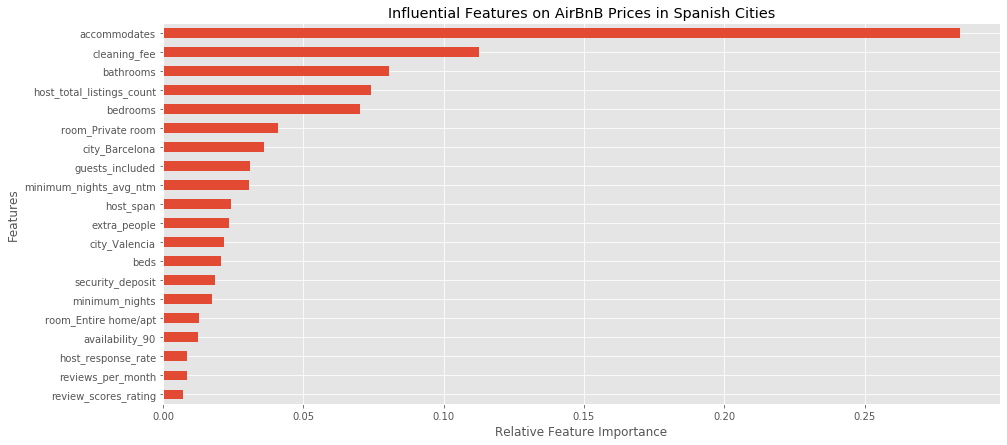

In [165]:
new_model = GradientBoostingRegressor(n_iter_no_change=5, n_estimators=best_params['n_estimators'], 
                                      learning_rate=best_params['learning_rate'], max_features=best_params['max_features'],
                                      min_samples_split=best_params['min_samples_split'], random_state=42)

fitted = apply_regression(new_model, X, y)

plot_importance(fitted, 20, X.columns)

After some adjusting and tuning through cross-validation, I've arrived at a model that can explain ~ 71.4% of the variance on the entire dataset. This is an improvement from the baseline predictions on the testing data subset of 62%.

It seems that this model is using the feature 'accomodates' (number of people able to be accommodated per listing) to explain the majority of the variance from the target variable 'Price'. 

Let's see how the same model performs, if this feature is removed from the dataset.

==========Results==========

Model R-square: 0.7053986729363173

Model MSE: 0.4038074203712785

Model Fitting Runtime: 19.866814851760864

Total Runtime: 20.114862203598022


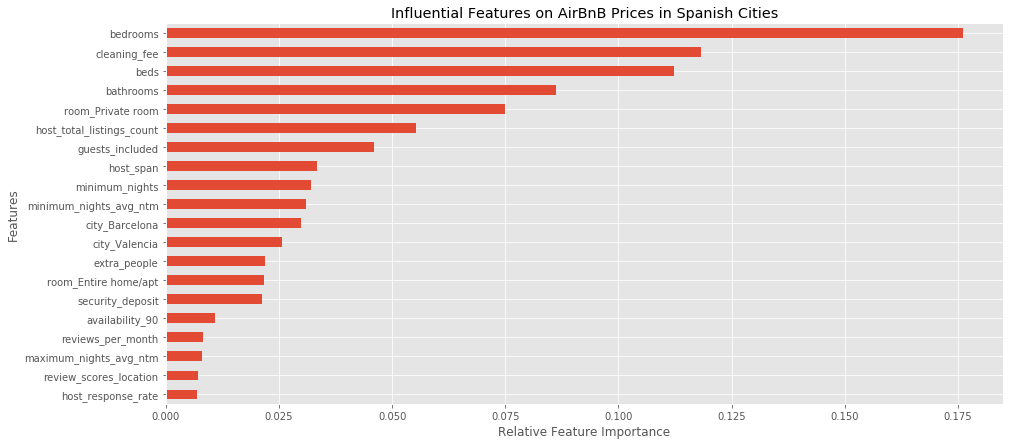

In [166]:
X_without_acc = X.loc[:, X.columns != 'accommodates']

fitted_2 = apply_regression(new_model, X_without_acc, y)
plot_importance(fitted_2, 20, X_without_acc.columns)

# Question 3 Conclusions

With the top feature removed from the dataset, the regression model performs at the same level, however it uses the feature 'bedrooms' to explain most of the variance in the predictions. 'cleaning_fee', 'bathrooms', and 'room_Private room' appear to be relatively important as well when predicting prices of listings. A cleaning fee on a property, and the bonus of extra bathrooms, are sure to drive up costs of a property. Adversely, if someone is renting out a Private room as a listing instead of an entire home/apartment, this too would have an affect on how much the price is. 

Another notable finding is that 'city_Barcelona' appears in the top 10 features for the first application of the model. As we saw in the earlier questions, this is the more expensive city as far as average listing prices go. 'city_Valencia', what I found to be the least expensive, is also being used to explain variance in prediction of prices here. 